# Nishika チュートリアル

[日本酒銘柄画像検索のチュートリアル実践ファイル](https://competition.nishika.com/competitions/sake/topics/588)

In [1]:
!nvidia-smi

Thu Jun 29 11:30:41 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.182.03   Driver Version: 470.182.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A6000    Off  | 00000000:17:00.0 Off |                  Off |
| 30%   59C    P0    81W / 300W |      0MiB / 48682MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
import collections
import math
import os
import random
import typing
from pathlib import Path

import faiss
import japanize_matplotlib
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import seaborn as sns
import timm
import torch
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from albumentations import Compose, Normalize, Resize
from albumentations.pytorch.transforms import ToTensorV2
from PIL import Image
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from torch import nn
from torch.nn import CrossEntropyLoss, Parameter
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm

/root/.cache/pypoetry/virtualenvs/nihonshu-image-search-HYX01F-d-py3.9/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# !pip install japanize_matplotlib
# !pip install missingno
# !pip install timm
# !pip install albumentations

print(os.getcwd())

/home/user/code/src/code


In [7]:
BASE_DIR = Path("../")
DATA_DIR = BASE_DIR.joinpath("data")
FEATURES_DIR = BASE_DIR.joinpath("features")
OUT_DIR = BASE_DIR.joinpath("output")
INDEX_DIR = BASE_DIR.joinpath("index")
MODEL_DIR = BASE_DIR.joinpath("model")
CITE_IMG_DIR = Path("cite_images")
QUERY_IMG_DIR = Path("query_images")
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
EXP_NAME="cpt-sake-tutorial"


class CFG:
    img_size = 224
    model_name = "convnext_base"
    in_channels = 3
    embedding_dim = 128
    pretrained = True
    batch_size = 128
    n_workers = 0
    seed = 0

In [8]:
def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(CFG.seed)

# データ

In [9]:
cite_filepath = DATA_DIR.joinpath("cite.csv")
train_filepath = DATA_DIR.joinpath("train.csv")
test_filepath = DATA_DIR.joinpath("test.csv")
sub_filepath = DATA_DIR.joinpath("sample_submission.csv")
df_cite = pd.read_csv(cite_filepath)
df_train = pd.read_csv(train_filepath)
df_test = pd.read_csv(test_filepath)
df_sub = pd.read_csv(sub_filepath)

## データの形式，概要確認

In [10]:
df_cite.shape

(109481, 2)

In [11]:
df_cite.head()

,cite_gid,cite_filename
0,100000001,100000001.jpg
1,100000002,100000002.jpg
2,100000003,100000003.jpg
3,100000004,100000004.jpg
4,100000005,100000005.jpg


In [46]:
df_cite.is

,cite_gid,cite_filename
0,100000001,100000001.jpg
1,100000002,100000002.jpg
2,100000003,100000003.jpg
3,100000004,100000004.jpg
4,100000005,100000005.jpg


In [47]:
df_train.shape

(108160, 4)

AttributeError: 'DataFrame' object has no attribute 'is_null'

## 訓練データの brand_id, meigara

訓練データ内のbrand_idの種類数：2515


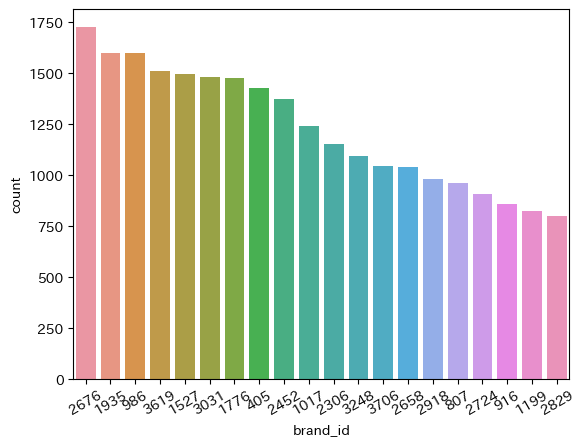

In [31]:
topn = 20
print("訓練データ内のbrand_idの種類数：{:4d}".format(df_train["brand_id"].nunique()))
ax = sns.countplot(x = df_train["brand_id"], order=pd.value_counts(df_train['brand_id']).iloc[:topn].index)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
plt.show()

訓練データ内のmeigaraの種類数：2498


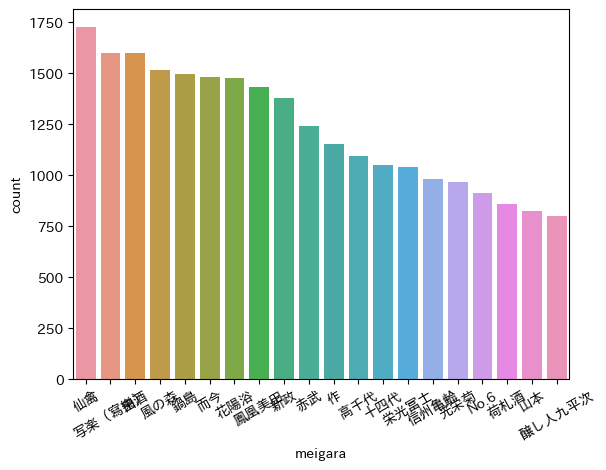

In [32]:
topn = 20
print("訓練データ内のmeigaraの種類数：{:4d}".format(df_train["meigara"].nunique()))
ax = sns.countplot(x = df_train["meigara"], order=pd.value_counts(df_train['meigara']).iloc[:topn].index)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
plt.show()